# Description

Data Generation (40 points):
- Generating following relations: linear, quadratic, cubic, sinusoidal
- Generating all relations above + add noise on input
- Generating all relations above + partial display (50%-100% through offset)

Iterational Training:
- Train on good data first
- Train on noisy data
- Train on partial data
- Train on noisy + partial data

Save Model:
- local folder

# Libraries

In [1]:
RANDOM_STATE = 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score

import tensorflow as tf

In [3]:
import math
import random
random.seed(RANDOM_STATE)

# Data Generation

In [326]:
def rescale(x):
    x = (x - min(x)) / (max(x) - min(x))
    x *= 0.8
    x += 0.1
    return x

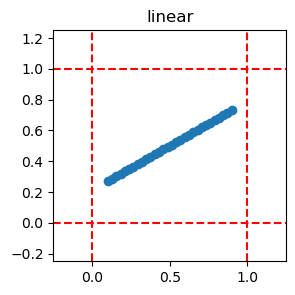

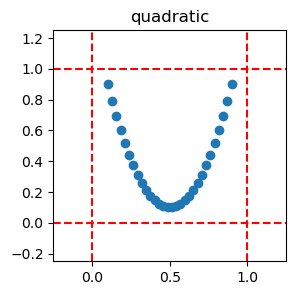

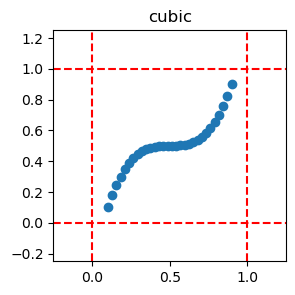

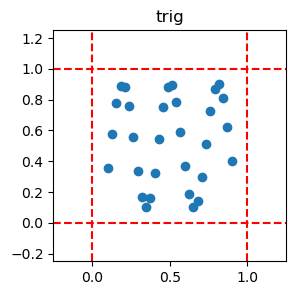

In [338]:
def linear(n):
    r = np.linspace(0, 1, n)
    angle_degrees = random.uniform(-90, 90)
    angle_radians = math.radians(angle_degrees)
    x = r * math.cos(angle_radians)
    y = r * math.sin(angle_radians)
    if -45 <= angle_degrees < 45:
        x = rescale(x)
        y += 0.5 - math.sin(angle_radians) / 2
    if angle_degrees < -45 or 45 <= angle_degrees:
        x += 0.5 - math.cos(angle_radians) / 2
        y = rescale(y)
    return x, y
def quadratic(n):
    x = np.linspace(-10, 10, n)
    y = x ** 2
    return rescale(x), rescale(y)
def cubic(n):
    x = np.linspace(-10, 10, n)
    y = x ** 3
    return rescale(x), rescale(y)
def trig(n):
    x = np.linspace(0, n, n)
    # fluctuating number of periods [1.5, 3]
    N_PERIODS = random.uniform(1.5, 3)
    three_periods = N_PERIODS * 2 * math.pi
    phase_shift = n * random.random() / N_PERIODS # random phase shift
    y = np.sin(three_periods / n * (x + phase_shift))
    return rescale(x), rescale(y)
def visualize(x, y, name):
    plt.figure(figsize=(3, 3))
    plt.xlim(-0.25, 1.25)
    plt.ylim(-.25, 1.25)
    plt.axvline(x=1, color='red', linestyle='--', label='Vertical Line')
    plt.axvline(x=0, color='red', linestyle='--', label='Vertical Line')
    plt.axhline(y=1, color='red', linestyle='--', label='Vertical Line')
    plt.axhline(y=0, color='red', linestyle='--', label='Vertical Line')
    plt.scatter(x, y)
    plt.title(name)
    plt.show()
    
N = 30

x, y = linear(N)
visualize(x, y, 'linear')
x, y = quadratic(N)
visualize(x, y, 'quadratic')
x, y = cubic(N)
visualize(x, y, 'cubic')
x, y = trig(N)
visualize(x, y, 'trig')

# Real World Adjustments

Apply to x, y:
- rescale [80%, 100%]
- shift [-10%, 10%]
- noise [-3%, 3%]
<br/> <br/>

free augmentation:
- mirror (specifically for cubic relation)

In [413]:
RESCALE_MIN = 0.8
RESCALE_MAX = 1
SHIFT_MIN = -0.1
SHIFT_MAX = 0.1
NOISE_MIN = -0.03
NOISE_MAX = 0.03

In [415]:
def modify(x, y):
    x *= random.uniform(RESCALE_MIN, RESCALE_MAX)
    y *= random.uniform(RESCALE_MIN, RESCALE_MAX)
    x += random.uniform(SHIFT_MIN, SHIFT_MAX)
    y += random.uniform(SHIFT_MIN, SHIFT_MAX)
    x += np.random.uniform(NOISE_MIN, NOISE_MAX, len(x))
    y += np.random.uniform(NOISE_MIN, NOISE_MAX, len(y))
    x, y = cut(x, y)
    return x, y

In [418]:
CUT_RANGE_MIN = 0.1
CUT_RANGE_MAX = 0.9

def cut(x, y):
    x_out = []
    y_out = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]
        if xi < CUT_RANGE_MIN or xi > CUT_RANGE_MAX:
            continue
        if yi < CUT_RANGE_MIN or yi > CUT_RANGE_MAX:
            continue
        x_out.append(xi)
        y_out.append(yi)
    return x_out, y_out

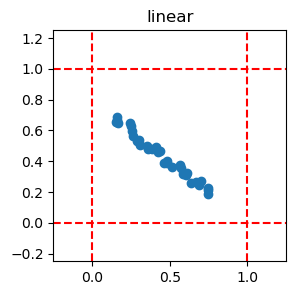

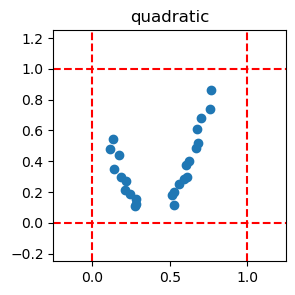

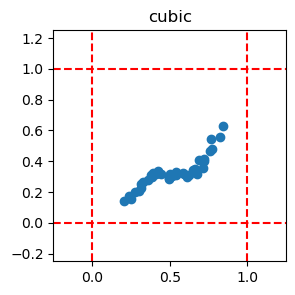

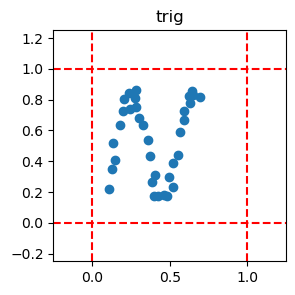

In [419]:
N = 40

x, y = linear(N)
x, y = modify(x, y)
visualize(x, y, 'linear')
x, y = quadratic(N)
x, y = modify(x, y)
visualize(x, y, 'quadratic')
x, y = cubic(N)
x, y = modify(x, y)
visualize(x, y, 'cubic')
x, y = trig(N)
x, y = modify(x, y)
visualize(x, y, 'trig')

# Dataset Generation

- To be processed like images we need to convert coordinates to matrices

In [422]:
SIZE_MATRIX = 64

In [423]:
def to_matrix(x, y):
    # when rounding to whole indexes, some values may get squashed
    # use SIZE_MATRIX - 1 and round
    matrix = np.zeros((SIZE_MATRIX, SIZE_MATRIX), dtype=int)
    
    def scale_resolution(axis):
        min_axis = np.min(axis)
        max_axis = np.max(axis)
        
        range_axis = max_axis - min_axis
        range_matrix = SIZE_MATRIX - 1
        
        return  np.round( (axis - min_axis) / range_axis * range_matrix ).astype(int)
    
    x = scale_resolution(x)
    y = scale_resolution(y)
    
    matrix[x, y] = 1
    return matrix

In [429]:
def generator_clean(n, n_points):
    out = []
    for i in range(n):
        # matric, linear, quadratic, cubic, trig
        iv = [0, 0, 0, 0, 0]
        selected_class = random.randint(0, 3)
        if selected_class == 0:
            x, y = linear(n_points)
            iv[1] = 1
        if selected_class == 1:
            x, y = quadratic(n_points)
            iv[2] = 1
        if selected_class == 2:
            x, y = cubic(n_points)
            iv[3] = 1
        if selected_class == 3:
            x, y = trig(n_points)
            iv[4] = 1
        iv[0] = to_matrix(x, y)
        out.append(iv)
    return out

In [430]:
test = generator_clean(12, 40)

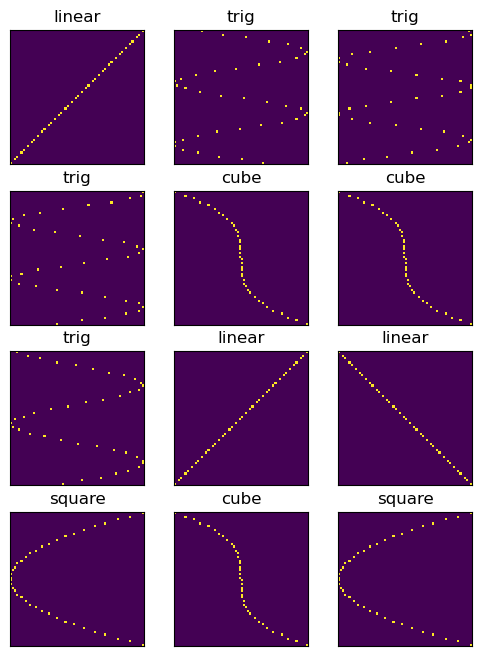

In [432]:
fig, axs = plt.subplots(4, 3, figsize=(6, 8))
x, y = 0, 0
for m, a, b, c, d in test:
    axs[y, x].matshow(m)
    if a == 1:
        title = 'linear'
    if b == 1:
        title = 'square'
    if c == 1:
        title = 'cube'
    if d == 1:
        title = 'trig'
    axs[y, x].set_title(title)
    axs[y, x].set_xticks([])
    axs[y, x].set_yticks([])
    if x == 0:
        x = 1
    elif x == 1:
        x = 2
    elif x == 2:
        x = 0
        y += 1

In [433]:
def generator_noisy(n, n_points):
    out = []
    for i in range(n):
        # matric, linear, quadratic, cubic, trig
        iv = [0, 0, 0, 0, 0]
        selected_class = random.randint(0, 3)
        if selected_class == 0:
            x, y = linear(n_points)
            x, y = modify(x, y)
            iv[1] = 1
        if selected_class == 1:
            x, y = quadratic(n_points)
            x, y = modify(x, y)
            iv[2] = 1
        if selected_class == 2:
            x, y = cubic(n_points)
            x, y = modify(x, y)
            iv[3] = 1
        if selected_class == 3:
            x, y = trig(n_points)
            x, y = modify(x, y)
            iv[4] = 1
        iv[0] = to_matrix(x, y)
        out.append(iv)
    return out

In [434]:
test_noisy = generator_noisy(12, 40)

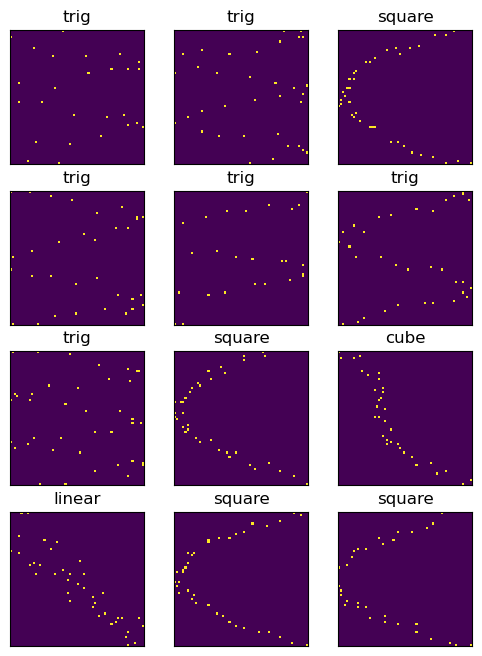

In [435]:
fig, axs = plt.subplots(4, 3, figsize=(6, 8))
x, y = 0, 0
for m, a, b, c, d in test_noisy:
    axs[y, x].matshow(m)
    if a == 1:
        title = 'linear'
    if b == 1:
        title = 'square'
    if c == 1:
        title = 'cube'
    if d == 1:
        title = 'trig'
    axs[y, x].set_title(title)
    axs[y, x].set_xticks([])
    axs[y, x].set_yticks([])
    if x == 0:
        x = 1
    elif x == 1:
        x = 2
    elif x == 2:
        x = 0
        y += 1

# Training

- train
  - clean data 500
  - noisy data 500
- valid
  - clean 100
  - noisy 100
- convolutional network input [64, 64] matrix
- convolutional network output [0, 0, 0, 0] probability of each class


In [436]:
train_clean = generator_clean(500, 40)
train_noisy = generator_noisy(500, 40)
train = train_clean + train_noisy

In [437]:
valid_clean = generator_clean(100, 40)
valid_noisy = generator_noisy(100, 40)
valid = valid_clean + valid_noisy

In [438]:
train[0][0].shape

(64, 64)

In [441]:
len(train)

1000

In [443]:
X_train = [row[0] for row in train]
y_train = [row[1:] for row in train]

X_valid = [row[0] for row in valid]
y_valid = [row[1:] for row in valid]

In [444]:
def step(x):
    return x.reshape((64, 64, 1))

X_train = list(map(step, X_train))
X_valid = list(map(step, X_valid))

In [445]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [454]:
backbone = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(64, 64, 1)
)
model = tf.keras.Sequential()
model.add(backbone)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [456]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',   # Monitor validation loss for improvement
    patience=4,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model weights
)

model.fit(x=X_train, 
          y=y_train, 
          batch_size=8,
          validation_data=(X_valid, y_valid), 
          epochs=20, 
          callbacks=[early_stopping], 
          verbose=1)

Epoch 1/20
125/125 [==============================] - 10s 78ms/step - loss: 0.5340 - accuracy: 0.9120 - val_loss: 79.8720 - val_accuracy: 0.2600
Epoch 2/20
125/125 [==============================] - 8s 67ms/step - loss: 0.2482 - accuracy: 0.9610 - val_loss: 35.8308 - val_accuracy: 0.2300
Epoch 3/20
125/125 [==============================] - 8s 66ms/step - loss: 0.0598 - accuracy: 0.9850 - val_loss: 13.1923 - val_accuracy: 0.2300
Epoch 4/20
125/125 [==============================] - 8s 66ms/step - loss: 0.0363 - accuracy: 0.9930 - val_loss: 0.9311 - val_accuracy: 0.7550
Epoch 5/20
125/125 [==============================] - 8s 66ms/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.1000 - val_accuracy: 0.9850
Epoch 6/20
125/125 [==============================] - 9s 68ms/step - loss: 0.0153 - accuracy: 0.9980 - val_loss: 1.3096 - val_accuracy: 0.7700
Epoch 7/20
125/125 [==============================] - 8s 66ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 3.0039e-04 - val_accuracy

In [457]:
z_valid = model.predict(x=X_valid)
z_valid_rounded = np.round(z_valid).astype(int)
accuracy_score(y_valid, z_valid_rounded)

7/7 [==============================] - 3s 187ms/step


0.98

In [458]:
z_valid_rounded[:5]

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [459]:
y_valid[:5]

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [465]:
z_linear = np.sum(z_valid_rounded[:, 0])
z_squared = np.sum(z_valid_rounded[:, 1])
z_cubed = np.sum(z_valid_rounded[:, 2])
z_trig = np.sum(z_valid_rounded[:, 3])

y_linear = np.sum(y_valid[:, 0])
y_squared = np.sum(y_valid[:, 1])
y_cubed = np.sum(y_valid[:, 2])
y_trig = np.sum(y_valid[:, 3])

In [468]:
categories = ['y_linear', 'z_linear', 'y_squared', 'z_squared', 'y_cubed', 'z_cubed', 'y_trig', 'z_trig']
values = [y_linear, y_squared, z_squared, y_cubed, z_linear, z_cubed, y_trig, z_trig]

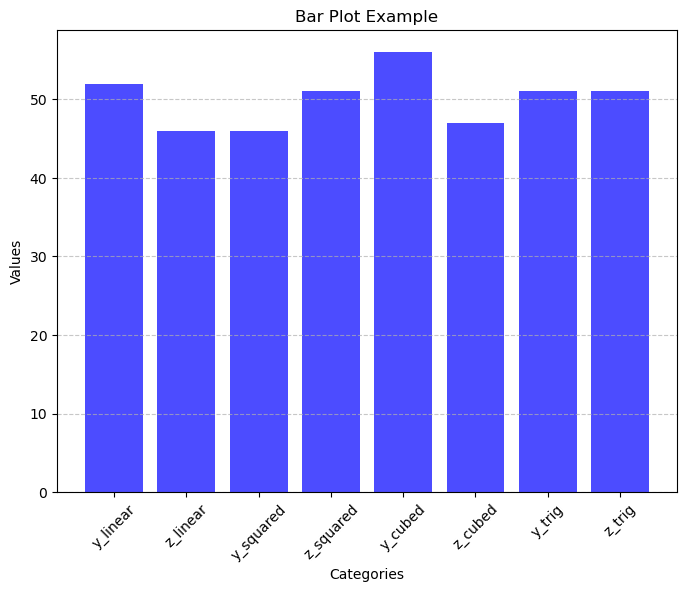

In [469]:
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.bar(categories, values, color='blue', alpha=0.7)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot Example')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines
plt.show()

<div style="background: CornflowerBlue; padding: 2rem; border-radius: 2rem;">
    So, we have trained a model that predicts one of four relations (linear, quadratic, cube, sinusoidal) with 0.98 accuracy. Now we can save that model -> write a script that will open that model and predict the relation for our front-end!!! 
</div>

In [470]:
model.save('predict')

INFO:tensorflow:Assets written to: predict/assets


INFO:tensorflow:Assets written to: predict/assets
